**Availability of CUDA and my root file**


In [1]:
from pathlib import Path

import os
import torch
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Torch version: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Ti


In [3]:
PROJECT_ROOT = Path.cwd()
print("Project root:", PROJECT_ROOT)

Project root: C:\Users\Abdul\OneDrive\Desktop\Varsity\Deep Learning\Dataset\notebooks


**Training and Testing Sets** 

In [26]:
rain_dir = asv2019_root / "ASVspoof2019_LA_train"
dev_dir   = asv2019_root / "ASVspoof2019_LA_dev"
eval_dir  = asv2019_root / "ASVspoof2019_LA_eval"

print("Train dir exists:", train_dir.exists())
print("Dev dir exists:", dev_dir.exists())
print("Eval dir exists:", eval_dir.exists())

train_flac_dir = train_dir / "flac"
print("Num train files:", len(list(train_flac_dir.glob("*.flac"))))

Train dir exists: True
Dev dir exists: True
Eval dir exists: True
Num train files: 25380


In [27]:
from pathlib import Path

DATA_ROOT = Path(r"C:\Users\Abdul\OneDrive\Desktop\Varsity\Deep Learning\Dataset")
asv2019_root = DATA_ROOT / "ASVSpoof2019" / "LA" / "LA"

cm_proto_dir = asv2019_root / "ASVspoof2019_LA_cm_protocols"

train_proto = cm_proto_dir / "ASVspoof2019.LA.cm.train.trn.txt"
dev_proto   = cm_proto_dir / "ASVspoof2019.LA.cm.dev.trl.txt"
eval_proto  = cm_proto_dir / "ASVspoof2019.LA.cm.eval.trl.txt"

print("Train proto exists:", train_proto.exists())
print("Dev proto exists:", dev_proto.exists())
print("Eval proto exists:", eval_proto.exists())


Train proto exists: True
Dev proto exists: True
Eval proto exists: True


**Protocol Files for Labels**

In [28]:
file_to_label = {}

with open(train_proto, "r") as f:
    for line in f:
        parts = line.strip().split()
        _, file_id, _, label, attack_id = parts
        file_to_label[file_id + ".flac"] = (label, attack_id)

print("Number of train entries:", len(file_to_label))
print("First 5:", list(file_to_label.items())[:5])


Number of train entries: 25380
First 5: [('LA_T_1138215.flac', ('-', 'bonafide')), ('LA_T_1271820.flac', ('-', 'bonafide')), ('LA_T_1272637.flac', ('-', 'bonafide')), ('LA_T_1276960.flac', ('-', 'bonafide')), ('LA_T_1341447.flac', ('-', 'bonafide'))]


**Visualize Example**

In [29]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [30]:
example_path = next(train_flac_dir.glob("*.flac"))
example_name = example_path.name
label, attack = file_to_label[example_name]

print("Example file:", example_name)
print("Label:", label, "| Attack:", attack)
y, sr = librosa.load(example_path, sr=16000)
print("Audio shape:", y.shape, "Sample rate:", sr)

Example file: LA_T_1000137.flac
Label: A04 | Attack: spoof
Audio shape: (40006,) Sample rate: 16000


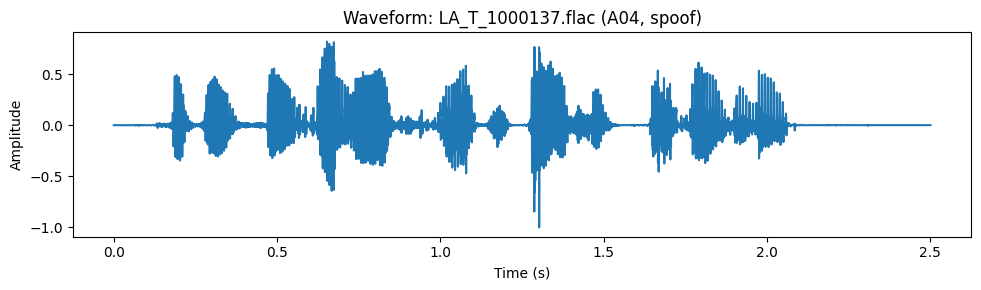

In [31]:
plt.figure(figsize=(10, 3))
t = np.linspace(0, len(y)/sr, num=len(y))
plt.plot(t, y)
plt.title(f"Waveform: {example_name} ({label}, {attack})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


In [33]:
import librosa
import inspect

print("Librosa version:", librosa.__version__)
print("melspectrogram is from:", inspect.getsourcefile(librosa.feature.melspectrogram))


Librosa version: 0.11.0
melspectrogram is from: C:\Users\Abdul\anaconda3\envs\dl\lib\site-packages\librosa\feature\spectral.py


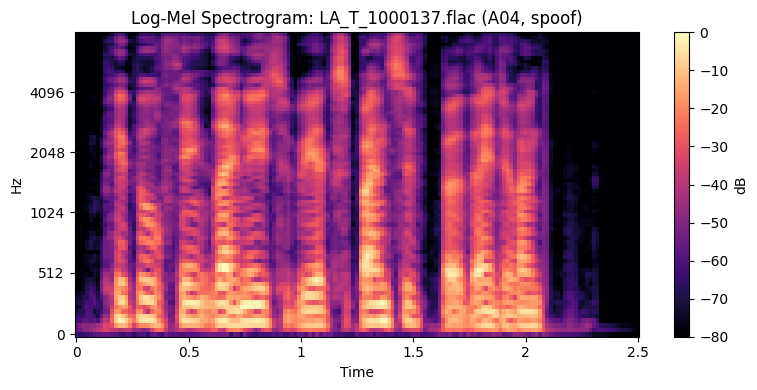

In [34]:
mel = librosa.feature.melspectrogram(
    y=y,
    sr=sr,
    n_fft=1024,
    hop_length=256,
    n_mels=80,
)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(8, 4))
librosa.display.specshow(
    mel_db,
    sr=sr,
    hop_length=256,
    x_axis="time",
    y_axis="mel",
)
plt.colorbar(label="dB")
plt.title(f"Log-Mel Spectrogram: {example_name} ({label}, {attack})")
plt.tight_layout()
plt.show()


**Dataset Class for ASVspoof LA: Raw Dataset to clean tensors**


In [57]:
class ASVspoof2019LADataset(Dataset):
    def __init__(self, split="train"):
        assert split in {"train", "dev", "eval"}
        
        if split == "train":
            self.base_dir = train_dir
            self.proto_path = train_proto
        elif split == "dev":
            self.base_dir = dev_dir
            self.proto_path = dev_proto
        else:
            self.base_dir = eval_dir
            self.proto_path = eval_proto

        self.entries = parse_protocol(self.proto_path, self.base_dir)
        print(f"{split} split: {len(self.entries)} files")

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        audio_path, label, attack_id = self.entries[idx]

        y, sr = librosa.load(audio_path, sr=16000)

        mel = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=1024,
            hop_length=256,
            n_mels=80,
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # 🔹 NEW: pad or truncate to fixed length
        mel_fixed = pad_or_truncate(mel_db, max_frames=400)

        mel_tensor = torch.from_numpy(mel_fixed).float().unsqueeze(0)  # [1, 80, 400]
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mel_tensor, label_tensor
        
 


In [58]:
   def pad_or_truncate(mel_db, max_frames=400):
        """
        mel_db: np.array of shape [n_mels, T]
        Returns: np.array of shape [n_mels, max_frames]
        """
        n_mels, T = mel_db.shape
    
        if T < max_frames:
            pad_width = ((0, 0), (0, max_frames - T))
            mel_fixed = np.pad(
                mel_db,
                pad_width=pad_width,
                mode="constant",
                constant_values=mel_db.min(),
            )
        else:
            mel_fixed = mel_db[:, :max_frames]
    
        return mel_fixed

In [59]:
batch_size = 8

train_dataset = ASVspoof2019LADataset(split="train")
dev_dataset   = ASVspoof2019LADataset(split="dev")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

dev_loader = DataLoader(
    dev_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)


train split: 25380 files
dev split: 24844 files


In [60]:
batch_size = 8

train_dataset = ASVspoof2019LADataset(split="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

batch_mel, batch_labels = next(iter(train_loader))

print(batch_mel.shape, batch_labels)


train split: 25380 files
torch.Size([8, 1, 80, 400]) tensor([0, 1, 1, 1, 1, 1, 0, 1])
